<Axes: title={'center': 'choose_one:confidence'}, xlabel='choose_one'>

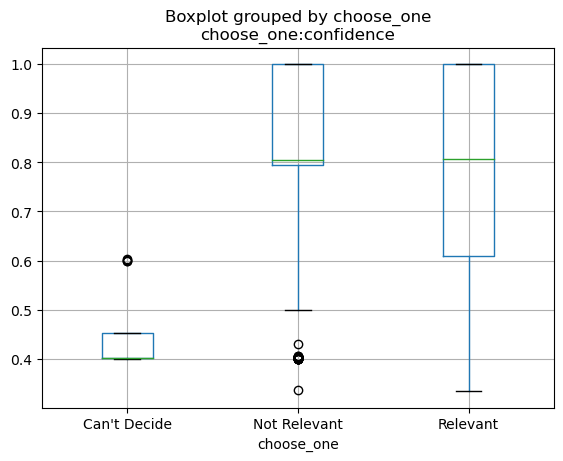

In [5]:
import pandas as pd

df = pd.read_csv('./data/disaster-tweets.csv', encoding='ISO-8859-1')

# Plot a boxplot. I want both "Relevant" and "Not Relevant" from the "choose_one" column. For each of them, I want to see the confidence score.
df.boxplot(column='choose_one:confidence', by='choose_one')


In [ ]:
# Clean some columns

# The `keyword` column has some string values like 'airplane%20accident', which should be 'airplane accident'.
# We can use `urllib.parse.unquote` to decode the string.
from urllib.parse import unquote

df['keyword'] = df['keyword'].apply(lambda x: unquote(x) if pd.notnull(x) else x)
# Print out all unique values in the `keyword` column
print(df['keyword'].unique())

columns_to_remove = ['_golden', '_unit_state', 'choose_one_gold']

df = df.drop(columns_to_remove, axis=1)


In [ ]:
import matplotlib.pyplot as plt

# Plot the counts of each classification
df['choose_one'].value_counts().plot(kind='bar')
plt.title('Distribution of Tweet Classification')
plt.xlabel('Classification')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
df['choose_one:confidence'].plot(kind='hist', edgecolor='black', bins=10)
plt.title('Histogram of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
import seaborn as sns

sns.histplot(data=df, x='choose_one:confidence', hue='choose_one', element='step', stat="density", common_norm=False)
plt.title('Distribution of Confidence Scores by Classification')
plt.show()


In [ ]:
# Remove links from the `text` column
import re

def clean_text(text: str):
  text = re.sub(r'https?://\S+', '', text) # Remove link
  text = re.sub(r'\n',' ', text) # Remove line breaks
  text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
  return text

df['text'] = df['text'].apply(lambda x: clean_text(x))

# Remove punctuation from the `text` column
import string

df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

print(df['text'].head())


In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

# Apply the tokenizer to each row of the 'text' column
df['tokens'] = df['text'].apply(
    lambda x: [token.lower() for token in tokenizer.tokenize(str(x))])

# Print the first five rows of the new column
print(df[['text', 'tokens']].head())

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

df['tokens_without_stopwords'] = df['tokens'].apply(
    lambda x: [word for word in x if word.lower() not in stop_words])

print(df[['tokens', 'tokens_without_stopwords']].head())

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

df['stemmed_tokens'] = df['tokens_without_stopwords'].apply(
    lambda x: [stemmer.stem(word) for word in x])

print(df[['tokens_without_stopwords', 'stemmed_tokens']].head())

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df["text_lemmatized"] = df["tokens_without_stopwords"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

print(df[['tokens_without_stopwords', 'text_lemmatized']].head())


In [ ]:
# Compare the stemmed and lemmatized versions of the first 20 tweets
for i in range(5):
    print('Original:', df['tokens_without_stopwords'][i])
    print('Stemmed:', df['stemmed_tokens'][i])
    print('Lemmatized:', df['text_lemmatized'][i])
    print()
    

In [ ]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens  
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    # corpus used for spell correction
    corrector="twitter", 
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

df['cleaned_text'] = df['text'].apply(lambda x: " ".join(text_processor.pre_process_doc(x)))

print(df[['text', 'cleaned_text']].head())

In [ ]:
import re


def remove_special_characters_and_numbers(text):
    # This pattern matches any character that is NOT a word character (represented by \W)
    # or a whitespace (represented by \s). Additionally, it matches digits (represented by \d).
    return re.sub(r'[\W_]+|\d+', ' ', text)


df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_special_characters_and_numbers(x))

nonimportant_words = ['hashtag', 'allcaps', 'url', 'repeated', 'number']

def remove_nonimportant_words(text):
    return ' '.join([word for word in text.split() if word not in nonimportant_words])

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_nonimportant_words(x))

print(df[['text', 'cleaned_text']].head())

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the texts together
text = ' '.join(df['cleaned_text'])

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Create anddislaya word cloud of the `keyword` column
text = ' '.join(df['keyword'].astype(str))

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from collections import Counter
import seaborn as sns

# Tokenize and get the word frequency
words = ' '.join(df['cleaned_text']).split()
frequency = Counter(words)

# Select top N words
N = 20
most_common = frequency.most_common(N)
words, counts = zip(*most_common)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title(f"Top {N} Most Frequent Words")
plt.xlabel("Frequency")
plt.show()

# Plot the most common words in the `keyword` column
words = ' '.join(df['keyword'].astype(str)).split()
frequency = Counter(words)

N = 10 
most_common = frequency.most_common(N)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title(f"Top {N} Most Frequent Keywords")
plt.xlabel("Frequency")
plt.show()

# Keywords where the `choose_one` column is "Relevant"
relevant_keywords = df[df['choose_one'] == 'Relevant']['keyword'].astype(str)
words = ' '.join(relevant_keywords).split()
frequency = Counter(words)

N = 10 
most_common = frequency.most_common(N)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title(f"Top {N} Keywords Where `choose_one` is Relevant")
plt.xlabel("Frequency")
plt.show()

# Keywords where the `choose_one` column is "Not Relevant"
nonrelevant_keywords = df[df['choose_one'] == 'Not Relevant']['keyword'].astype(str)
words = ' '.join(nonrelevant_keywords).split()
frequency = Counter(words)

N = 10 
most_common = frequency.most_common(N)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title(f"Top {N} Keywords Where `choose_one` is Not Relevant")
plt.xlabel("Frequency")
plt.show()


In [ ]:
df['text_length'] = df['cleaned_text'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Length")
plt.ylabel("Number of Texts")
plt.show()


In [ ]:
sns.boxplot(data=df, x='choose_one', y='text_length', palette='pastel')
plt.title("Boxplot of Text Lengths by Category")
plt.show()

# This shows us that if a tweet is marked as relevant, it is more likely to be longer than a tweet that is not relevant.


We now want to check what columns are categorical features. We suspect that `_unit_state`, `choose_one` and `choose_one_gold` may be categorical.

In [ ]:
# Visualize each column named above using a bar chart
def plot_bar_chart(df, column):
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Tweets')
    plt.show()

plot_bar_chart(df, '_unit_state')
plot_bar_chart(df, 'choose_one')
plot_bar_chart(df, 'choose_one_gold')

The `choose_one_gold` column seems to be a rare occurrence. Perhaps we should drop it. Rather, we'll perhaps stick to `choose_one`. 

In [ ]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()

# Initialize empty list for potential categorical columns
potential_categorical_columns = []

# Iterate over non-numeric columns
for col in non_numeric_columns:
    try:
        # If unique values are less than 5% of total rows, consider the column as categorical
        if df[col].nunique() / len(df) < 0.05:
            potential_categorical_columns.append(col)
    except TypeError:
        # This will catch columns that cause the TypeError (e.g., columns with list-type values)
        # You can either skip these columns or handle them differently
        pass

print(potential_categorical_columns)

In [ ]:
import pandas as pd

# Use get_dummies to perform one-hot encoding on the 'choose_one' column
df = pd.get_dummies(df, columns=['choose_one'], prefix=['choose_one'])

# The dataframe df now has new columns corresponding to the unique values in the 'choose_one' column
# Each new column will be named "choose_one_<value_from_choose_one_column>"

# Print the head of all column containing the prefix 'choose_one'
print(df.filter(regex='choose_one').head())

We assume the following: Regarding `_trusted_judgements`, the `_trusted_judgments` column likely refers to the number of trusted evaluators or annotators who have judged or labeled the content of the tweet. Higher numbers in this column might suggest greater consensus or confidence in the label assigned to a particular tweet, since more individuals have weighed in on its content. Conversely, a lower number could mean fewer judgments, and potentially less certainty in the label, especially if there's disagreement among annotators.

In order to know if we should standardize or normalize the `_trusted_judgements` column, we need to know the distribution of the values in the column.


In [ ]:
# Check if the range of `_trusted_judgments` is very wide
print(df['_trusted_judgments'].describe())

# Plot the distribution of `_trusted_judgments`
plt.hist(df['_trusted_judgments'], bins=10, edgecolor='black')
plt.title("Distribution of _trusted_judgments")
plt.xlabel("_trusted_judgments")
plt.ylabel("Number of Tweets")
plt.show()

# Only plot in the range of 0 to 20
plt.hist(df['_trusted_judgments'], bins=10, range=(0, 20), edgecolor='black')
plt.title("Distribution of _trusted_judgments")
plt.xlabel("_trusted_judgments")
plt.ylabel("Number of Tweets")
plt.show()

We can visually see, and confirmed by the cell above, that most tweets have a `_trusted_judgements` value of 5. We can also see that the distribution is skewed a bit to the right.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardizing _trusted_judgments
scaler = StandardScaler()
df['_trusted_judgments_standardized'] = scaler.fit_transform(
    df['_trusted_judgments'].values.reshape(-1, 1))

# Normalizing _trusted_judgments
scaler = MinMaxScaler()
df['_trusted_judgments_normalized'] = scaler.fit_transform(
    df['_trusted_judgments'].values.reshape(-1, 1))

# Print the normalized and standardized columns
print(df[['_trusted_judgments_standardized', '_trusted_judgments_normalized']].head())


It might be interesting to check if there's a correlation between the number of `_trusted_judgments` (normalized) and the `choose_one:confidence` column. Intuitively, tweets with more judgments might be expected to have higher confidence scores, indicating consensus among annotators.

In [ ]:
# Check the correlation between `_trusted_judgments_normalized` and `choose_one:confidence`
print(df['_trusted_judgments_normalized'].corr(df['choose_one:confidence']))

# Visualize the relationship between `_trusted_judgments_normalized` and `choose_one:confidence`
plt.scatter(df['_trusted_judgments_normalized'], df['choose_one:confidence'])
plt.title("Relationship between _trusted_judgments_normalized and choose_one:confidence")
plt.xlabel("_trusted_judgments_normalized")
plt.ylabel("choose_one:confidence")
plt.show()

Based on the plot above, we can see that tweets with a high normalized `_trusted_judgements` value tend to have higher confidence scores. This suggests that there is some correlation between the two variables. However, perhaps we should remove some data with a very low `_trusted_judgements` value (e.g. `< 0.1`), since the confidence scores for these tweets are all over the place. This may distort the correlation.

In [ ]:
# Remove data with a `_trusted_judgements_normalized` value lower than 0.1
df = df[df['_trusted_judgments_normalized'] > 0.1]

# Check the correlation between `_trusted_judgments_normalized` and `choose_one:confidence` again
print(df['_trusted_judgments_normalized'].corr(df['choose_one:confidence']))

# Plot the same scatterplot again
plt.scatter(df['_trusted_judgments_normalized'], df['choose_one:confidence'])
plt.title("Relationship between _trusted_judgments_normalized and choose_one:confidence")
plt.xlabel("_trusted_judgments_normalized")
plt.ylabel("choose_one:confidence")
plt.show()

# Heatmap of the same columns
sns.heatmap(df[['_trusted_judgments_normalized', 'choose_one:confidence']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Inspect the `_trusted_judgments_standardized` column
print(df['_trusted_judgments_standardized'].describe())
print("----------")

# Check if any z-score in the `_trusted_judgments_standardized` column is unusually high or low
print(df['_trusted_judgments_standardized'].abs().sort_values(ascending=False).head(10))
print("----------")

# Check which tweets deserved the unusually high or low z-scores. Include the full `text` column.
print([
    df['text'].iloc[
      # Get the index of the top 10 highest and lowest z-scores
      df['_trusted_judgments_standardized'].abs().sort_values(ascending=False).head(10).index
    ]
])
print("----------")

In [ ]:
# Create a boxplot for the `_trusted_judgments_standardized` column
plt.boxplot(df['_trusted_judgments_standardized'])
plt.title("Boxplot of _trusted_judgments_standardized")
plt.show()

# Create a boxplot of the `choose_one:confidence` column
plt.boxplot(df['choose_one:confidence'])
plt.title("Boxplot of choose_one:confidence")
plt.show()

# Describe the `choose_one:confidence` column
print(df['choose_one:confidence'].describe())


In [ ]:
# Check the tweets with a `choose_one:confidence` value below 0.9. Display the full `text` column.
pd.set_option('display.max_colwidth', None)
print(df[df['choose_one:confidence'] < 0.9]['text'])

As we can see from the boxplot of outliers and the actual tweets with confidence below 0.9, there are still many tweets that concern a disaster that have a lower confidence score.

From the box plot for the `choose_one:confidence` column, we can draw several insights:

**Median:**

- The median value is 1. This indicates that half of the values in the choose_one:confidence column are at 1, and the other half are below 1. Given the nature of confidence scores, this likely indicates that many of the judgments are made with full confidence.

**First Quartile (Q1) and Third Quartile (Q3):**

- Lower quartile (Q1) at about 0.95: About 25% of the data points have confidence values below 0.95.
- Upper quartile (Q3) at 1: About 75% of the data points have confidence values below 1, which is also the median. 
- This indicates that the majority of the data points (from the median to the upper quartile) have the maximum confidence value of 1.

**Minimum:**

- The smallest non-outlier value is 0.90. This is the lowest confidence value that is not considered an outlier.

**Outliers:**

- The many small dots from 0.60 up to 0.90 represent the outliers in our dataset. These are individual observations that fall far from the rest of the data, below the minimum value. The presence of many dots suggests that there are several data points with confidence levels significantly lower than the majority of the dataset.